Import necessary libraries

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.pyplot as plt

In [44]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [45]:
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 256 * 28 * 28)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Hyperparameters

In [46]:
image_size = 224
rotation = 10
normalization_mean = [0.5, 0.5, 0.5]
normalization_std = [0.5, 0.5, 0.5]

learning_rate = 0.03
batch_size = 32
epochs = 10

Image processing steps

In [47]:
train_transform = transforms.Compose([
    # Resize the images 
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),  # Flip the images horizontally at random
    # Rotate the images
    transforms.RandomRotation(rotation),
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    # Normalize the pixel values to [-1, 1]
    transforms.Normalize(normalization_mean, normalization_std)
])
test_transform = transforms.Compose([
    # Resize the images to 224x224 pixels
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    # Normalize the pixel values to [-1, 1]
    transforms.Normalize(normalization_mean, normalization_std)
])

In [48]:
# Load the dataset
train_dataset = datasets.ImageFolder('data/train', transform=train_transform)
test_dataset = datasets.ImageFolder('data/test', transform=test_transform)

Define the loss function and optimizer

In [49]:
model = CancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [50]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

Train The model

In [51]:
import matplotlib.pyplot as plt

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(epochs):
    train_loss = 0
    train_correct = 0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_accs.append(train_acc)

    # Test the model
    model.eval()
    test_loss = 0
    test_correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            test_correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc = 100. * test_correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    # Calculate F1 score
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    f1_score = metrics.f1_score(all_targets, all_preds, average='macro')

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%, F1 score: {:.4f}'
          .format(epoch+1, epochs, train_loss, train_acc, test_loss, test_acc, f1_score))


Epoch [1/10], Train Loss: 0.0201, Train Acc: 62.65%, Test Loss: 0.0163, Test Acc: 70.61%, F1 score: 0.7039
Epoch [2/10], Train Loss: 0.0164, Train Acc: 73.27%, Test Loss: 0.0145, Test Acc: 78.03%, F1 score: 0.7777
Epoch [3/10], Train Loss: 0.0142, Train Acc: 77.44%, Test Loss: 0.0129, Test Acc: 80.00%, F1 score: 0.7997
Epoch [4/10], Train Loss: 0.0130, Train Acc: 79.71%, Test Loss: 0.0159, Test Acc: 77.27%, F1 score: 0.7686
Epoch [5/10], Train Loss: 0.0129, Train Acc: 80.05%, Test Loss: 0.0124, Test Acc: 82.88%, F1 score: 0.8281
Epoch [6/10], Train Loss: 0.0121, Train Acc: 82.18%, Test Loss: 0.0122, Test Acc: 82.88%, F1 score: 0.8281
Epoch [7/10], Train Loss: 0.0121, Train Acc: 81.87%, Test Loss: 0.0113, Test Acc: 84.55%, F1 score: 0.8452
Epoch [8/10], Train Loss: 0.0117, Train Acc: 81.91%, Test Loss: 0.0114, Test Acc: 83.79%, F1 score: 0.8379
Epoch [9/10], Train Loss: 0.0114, Train Acc: 82.67%, Test Loss: 0.0111, Test Acc: 82.12%, F1 score: 0.8207
Epoch [10/10], Train Loss: 0.0113, Tr

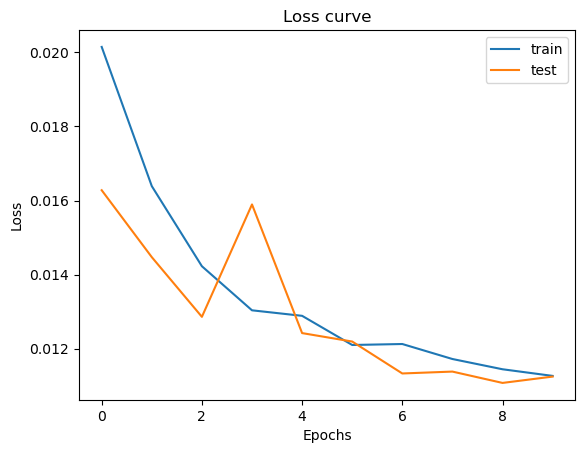

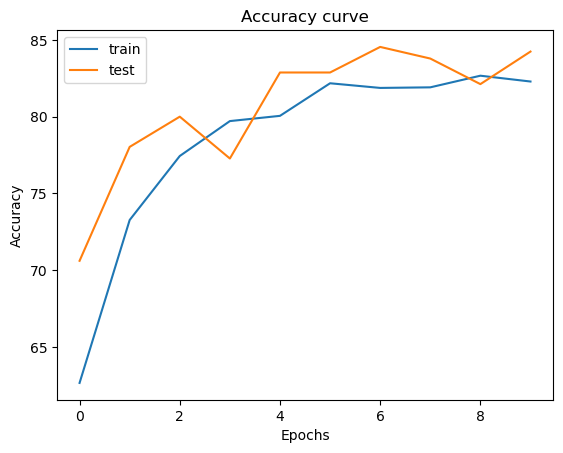

In [52]:
# Plot loss and accuracy curves
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Save the model

In [53]:
torch.save(model.state_dict(), 'cancer_cnn.pth')